In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) #change when running in a different directory
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df

# Base Case Summer
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [7]:
merged_data_summer = create_df('summer')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [8]:
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_summer['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_base_case_summer")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 0 #no heatpump in this case
power_hp = [0] * len(price)  # Heat pump power is zero in this case

### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [ ]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_summer,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_summer,model, duration_wm, wm_start)

charging_ev, soc_ev, binary_ev = EV_no_feed_in(Time_interval,merged_data_summer,model)

penalty_cost, level_bin, levels, penalty_per_level, total_demand = peak_prices(Time_interval,merged_data_summer,model,
            inflexible_demand, binary_wm, binary_dishwasher, binary_dryer, charging_ev, power_wm, 
            power_dishwasher, max_power_ev, power_dryer, max_power_hp, power_hp)

### Run Optimization

In [10]:
# Electricity cost
electricity_cost = gp.quicksum(
    (price[t] *
        (merged_data_summer['Inflexible_Demand_(kWh)'][t] +
        power_dishwasher * binary_dishwasher[t] +
        power_wm * binary_wm[t] +
        power_dryer * binary_dryer[t] +
        charging_ev[t])) for t in range(Time_interval)
)
# Full objective: cost + penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20856 rows, 10078 columns and 58541 nonzeros
Model fingerprint: 0x73501b80
Variable types: 2016 continuous, 8062 integer (8062 binary)
Coefficient statistics:
  Matrix range     [3e-01, 3e+01]
  Objective range  [2e-03, 7e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [7e-02, 7e+01]
Presolve removed 15414 rows and 5051 columns
Presolve time: 0.28s
Presolved: 5442 rows, 5027 columns, 28511 nonzeros
Variable types: 680 continuous, 4347 integer (4347 binary)

Root relaxation: objective 3.905795e+01, 2706 iterations, 0.07 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   39.0

### Save Data

In [ ]:
# Prepare results DataFrame
results_df = merged_data_summer.copy()
results_df['Total_Demand'] = [total_demand[t].X for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [
    int(np.argmax([level_bin[t][i].X for i in range(len(levels)-1)]))
    for t in range(len(results_df))
]

# Add penalty cost per hour based on demand level
results_df['Penalty_Cost'] = [
    penalty_per_level[dl] for dl in results_df['Demand_Level']
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = results_df['Total_Demand'] * results_df['Spotmarket_(EUR/kWh)']

# Add total cost per hour (electricity + penalty)
results_df['Total_Cost'] = results_df['Electricity_Cost'] + results_df['Penalty_Cost']

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_big_M/", "results_basecase_summer.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_peak/results_basecase_summer.csv


# Base Case Winter
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [12]:
merged_data_winter = create_df('winter')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [13]:
price = merged_data_winter["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_winter['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_base_case_winter")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 0 #no heatpump in this case
power_hp = [0] * len(price)  # Heat pump power is zero in this case

### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [ ]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_winter,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_winter,model, duration_wm, wm_start)

charging_ev, soc_ev, binary_ev = EV_no_feed_in(Time_interval,merged_data_winter,model)

penalty_cost, level_bin, levels, penalty_per_level, total_demand = peak_prices(Time_interval,merged_data_winter,model,
            inflexible_demand, binary_wm, binary_dishwasher, binary_dryer, charging_ev, power_wm, 
            power_dishwasher, max_power_ev, power_dryer, max_power_hp, power_hp)

### Objective Function and Optimization

In [15]:
# Electricity cost
electricity_cost = gp.quicksum(
    (price[t] *
        (merged_data_winter['Inflexible_Demand_(kWh)'][t] +
        power_dishwasher * binary_dishwasher[t] +
        power_wm * binary_wm[t] +
        power_dryer * binary_dryer[t] +
        charging_ev[t])) for t in range(Time_interval)
)
# Full objective: cost + penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20856 rows, 10078 columns and 58541 nonzeros
Model fingerprint: 0xf3e36d7b
Variable types: 2016 continuous, 8062 integer (8062 binary)
Coefficient statistics:
  Matrix range     [3e-01, 3e+01]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [9e-02, 7e+01]
Presolve removed 15421 rows and 5057 columns
Presolve time: 0.64s
Presolved: 5435 rows, 5021 columns, 28497 nonzeros
Variable types: 678 continuous, 4343 integer (4343 binary)

Root relaxation: objective 4.533577e+01, 2725 iterations, 0.13 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   45.3

### Save Data

In [ ]:
# Prepare results DataFrame
results_df = merged_data_winter.copy()
results_df['Total_Demand'] = [total_demand[t].X for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [
    int(np.argmax([level_bin[t][i].X for i in range(len(levels)-1)]))
    for t in range(len(results_df))
]

# Add penalty cost per hour based on demand level
results_df['Penalty_Cost'] = [
    penalty_per_level[dl] for dl in results_df['Demand_Level']
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = results_df['Total_Demand'] * results_df['Spotmarket_(EUR/kWh)']

# Add total cost per hour (electricity + penalty)
results_df['Total_Cost'] = results_df['Electricity_Cost'] + results_df['Penalty_Cost']

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_big_M/", "results_basecase_winter.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_peak/results_basecase_winter.csv


# Case 1 Winter - with heatpump 
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [17]:
merged_data_winter_case_1 = create_df('winter')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [18]:
price = merged_data_winter_case_1["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_winter_case_1['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_case_1_winter")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 8

### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [ ]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_winter_case_1,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_winter_case_1,model, duration_wm, wm_start)

charging_ev, soc_ev, binary_ev = EV_no_feed_in(Time_interval,merged_data_winter_case_1,model)

power_hp = heat_pump(Time_interval,merged_data_winter_case_1,model,max_power_hp)

penalty_cost, level_bin, levels, penalty_per_level, total_demand = peak_prices(Time_interval,merged_data_winter_case_1,model,
            inflexible_demand, binary_wm, binary_dishwasher, binary_dryer, charging_ev, power_wm, 
            power_dishwasher, max_power_ev, power_dryer, max_power_hp,power_hp)


In [20]:
# Electricity cost
electricity_cost = gp.quicksum(
    (price[t] *
        (merged_data_winter_case_1['Inflexible_Demand_(kWh)'][t] +
        power_dishwasher * binary_dishwasher[t] +
        power_wm * binary_wm[t] +
        power_dryer * binary_dryer[t] +
        charging_ev[t] +
        power_hp[t])) for t in range(Time_interval)
)

# Full objective: cost + penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22200 rows, 12094 columns and 62571 nonzeros
Model fingerprint: 0xb307245a
Variable types: 4032 continuous, 8062 integer (8062 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+01]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [5e-05, 1e+02]
Presolve removed 15538 rows and 4355 columns
Presolve time: 0.24s
Presolved: 6662 rows, 7739 columns, 32360 nonzeros
Variable types: 2136 continuous, 5603 integer (5603 binary)

Root relaxation: objective 5.122981e+01, 3217 iterations, 0.06 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   51.

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Sevi\AppData\Roaming\Python\Python312\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


 20788 13166   55.47762   39  281   55.79432   54.66283  2.03%  10.0  165s
 20792 13169   55.16555   35  268   55.79432   54.66283  2.03%  10.0  170s
 20800 13174   55.61353   57  289   55.79432   54.66283  2.03%  10.0  175s
 20805 13177   55.27117   37  303   55.79432   54.66283  2.03%  10.0  180s
 20812 13182   55.19186   40  304   55.79432   54.66283  2.03%  10.0  185s
H20814 12522                      55.7716965   54.66283  1.99%  10.0  187s
H20814 11895                      55.7680665   54.66283  1.98%  10.0  187s
 20990 11968 infeasible   50        55.76807   54.66283  1.98%  10.3  190s
 22753 12565   55.30387   37  151   55.76807   54.85956  1.63%  10.3  195s
 24985 13277     cutoff   67        55.76807   54.93574  1.49%  10.2  200s
 27329 13994     cutoff   60        55.76807   54.99586  1.38%  10.2  205s
 29150 14499   55.42301   46  123   55.76807   55.02991  1.32%  10.2  211s
 30377 14764   55.57031   51  135   55.76807   55.04473  1.30%  10.2  215s
 32314 15176   55.68776  

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\Sevi\AppData\Roaming\Python\Python312\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


 46009 17629   55.41031   43  134   55.76807   55.15310  1.10%  10.4  265s
 46978 17727     cutoff   53        55.76807   55.15776  1.09%  10.4  271s
 48407 17951   55.62751   58   63   55.76807   55.16422  1.08%  10.4  275s
 50224 18187   55.72717   51   71   55.76807   55.17471  1.06%  10.4  280s
 51553 18344   55.66532   46   95   55.76807   55.18217  1.05%  10.4  286s
 52420 18549   55.43571   43  128   55.76807   55.18667  1.04%  10.5  293s
 53037 18553   55.71067   53   92   55.76807   55.19076  1.04%  10.5  296s
 53913 18612     cutoff   52        55.76807   55.19404  1.03%  10.5  302s
 54912 18683   55.47078   47  124   55.76807   55.19885  1.02%  10.5  306s
 56055 18793     cutoff   54        55.76807   55.20450  1.01%  10.5  310s
 58177 19555   55.45283   43  118   55.76807   55.21402  0.99%  10.5  315s
 60707 20701   55.30699   41  148   55.76807   55.22641  0.97%  10.5  321s
 62128 21250   55.56635   52   85   55.76807   55.23220  0.96%  10.6  325s
 63988 22065   55.60515  

### Save Data

In [ ]:
# Prepare results DataFrame
results_df = merged_data_winter_case_1.copy()
results_df['Total_Demand'] = [total_demand[t].X for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]
results_df['Heatpump_Power'] = [power_hp[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [
    int(np.argmax([level_bin[t][i].X for i in range(len(levels)-1)]))
    for t in range(len(results_df))
]

# Add penalty cost per hour based on demand level
results_df['Penalty_Cost'] = [
    penalty_per_level[dl] for dl in results_df['Demand_Level']
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = results_df['Total_Demand'] * results_df['Spotmarket_(EUR/kWh)']

# Add total cost per hour (electricity + penalty)
results_df['Total_Cost'] = results_df['Electricity_Cost'] + results_df['Penalty_Cost']

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_peak/", "results_case_1_winter.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/results_case_1_winter.csv


Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_peak/results_case_1_winter.csv


# Case 2 Summer 
## PV Generation without feed-in
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [3]:
merged_data_summer_case_2 = create_df('summer')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [4]:
price = merged_data_summer_case_2["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_summer_case_2['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_case_2_summer")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 0 #summer -> heatpump not in use
power_hp = [0] * Time_interval #summer -> heatpump not in use
kwh_per_km = 0.2  # kWh per km driven

Set parameter Username
Set parameter LicenseID to value 2654951
Academic license - for non-commercial use only - expires 2026-04-21


### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [5]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_summer_case_2,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_summer_case_2,model, duration_wm, wm_start)

charging_ev, soc_ev, binary_ev = EV_no_feed_in(Time_interval,merged_data_summer_case_2,model)

pv, load, unmet, curtail, pv_maxed_binary, total_demand,penalty_cost, level_bin, levels, penalty_per_level, demand_level= PV_no_feed_in_and_penalty(Time_interval,
                        merged_data_summer_case_2,model ,power_dishwasher,binary_dishwasher,power_wm,binary_wm,power_dryer,
                        binary_dryer,charging_ev,inflexible_demand,max_power_ev,power_hp)

### Objective Function

In [6]:
# Electricity cost
electricity_cost = gp.quicksum(price[t] * unmet[t] for t in range(Time_interval))

# Full objective: cost + penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22872 rows, 12094 columns and 65261 nonzeros
Model fingerprint: 0xddd09e35
Variable types: 2688 continuous, 9406 integer (8734 binary)
Coefficient statistics:
  Matrix range     [3e-01, 3e+01]
  Objective range  [2e-03, 2e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e-04, 6e+01]
Presolve removed 17042 rows and 6683 columns
Presolve time: 0.33s
Presolved: 5830 rows, 5411 columns, 28665 nonzeros
Variable types: 896 continuous, 4515 integer (4515 binary)

Root relaxation: objective 2.200795e+01, 3395 iterations, 0.08 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.0

### Save Data 

In [9]:
# Prepare results DataFrame
results_df = merged_data_summer_case_2.copy()
results_df['Total_Demand'] = [total_demand[t].getValue() for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]
results_df['Unmet'] = [unmet[t].X for t in range(len(results_df))]
results_df['Curtailed'] = [curtail[t].X for t in range(len(results_df))]
results_df['PV2H'] = [merged_data_summer_case_2['PV_energy_production_kWh'][t] - curtail[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [demand_level[t].X for t in range(len(results_df))]

# Add penalty cost per hour based on demand level
results_df['Penalty'] = [
    sum(
        penalty_per_level[i] * level_bin[t][i].X
        for i in range(len(penalty_per_level))
    )
    for t in range(len(results_df))
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = [
    price[t] * unmet[t].X for t in range(len(results_df))
]

# Add total cost per hour (electricity + penalty)
results_df['Total_Price'] = [
    results_df['Electricity_Cost'][t] + results_df['Penalty'][t]
    for t in range(len(results_df))
]

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_big_M/", "results_case_2_summer.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_big_M/results_case_2_summer.csv


# Case 2 Winter 
## PV Generation without feed-in
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [10]:
merged_data_winter_case_2 = create_df('winter')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [11]:
price = merged_data_winter_case_2["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_winter_case_2['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_case_2_winter")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 8

### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [13]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_winter_case_2,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_winter_case_2,model, duration_wm, wm_start)

charging_ev, soc_ev, binary_ev = EV_no_feed_in(Time_interval,merged_data_winter_case_2,model)

power_hp = heat_pump(Time_interval,merged_data_winter_case_2,model,max_power_hp)

pv, load, unmet, curtail, pv_maxed_binary, total_demand,penalty_cost, level_bin, levels, penalty_per_level, demand_level= PV_no_feed_in_and_penalty(Time_interval,
                            merged_data_winter_case_2,model,power_dishwasher,binary_dishwasher
                            ,power_wm,binary_wm,power_dryer,binary_dryer,charging_ev,inflexible_demand,max_power_ev,power_hp)

### Objective Function

In [ ]:
# Electricity cost
electricity_cost = gp.quicksum(price[t] * unmet[t] for t in range(Time_interval))

# Full objective: cost + penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 24216 rows, 14110 columns and 69291 nonzeros


Model fingerprint: 0x40b2217c
Variable types: 4704 continuous, 9406 integer (8734 binary)
Coefficient statistics:
  Matrix range     [3e-01, 3e+01]
  Objective range  [2e-04, 2e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [5e-05, 1e+02]
Presolve removed 17354 rows and 6108 columns
Presolve time: 0.22s
Presolved: 6862 rows, 8002 columns, 33669 nonzeros
Variable types: 2314 continuous, 5688 integer (5688 binary)

Root relaxation: objective 4.557428e+01, 5232 iterations, 0.10 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   45.57428    0  295          -   45.57428      -     -    0s
H    0     0                      60.1745298   45.57428  24.3%     -    0s
H    0     0                      58.6133414   45.57428  22.2%     -    0s
H    0     0                      58.4990864   45.57428  22.1%     -    0s
     0     0   46.17953    0  2

### Save Results

In [ ]:
# Prepare results DataFrame
results_df = merged_data_winter_case_2.copy()
results_df['Total_Demand'] = [total_demand[t].getValue() for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]
results_df['Heatpump_Power'] = [power_hp[t].X for t in range(len(results_df))]
results_df['Unmet'] = [unmet[t].X for t in range(len(results_df))]
results_df['Curtailed'] = [curtail[t].X for t in range(len(results_df))]
results_df['PV2H'] = [merged_data_winter_case_2["PV_energy_production_kWh"][t] - curtail[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [demand_level[t].X for t in range(len(results_df))]

# Add penalty cost per hour based on demand level
results_df['Penalty'] = [
    sum(
        penalty_per_level[i] * level_bin[t][i].X
        for i in range(len(penalty_per_level))
    )
    for t in range(len(results_df))
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = [
    price[t] * unmet[t].X for t in range(len(results_df))
]

# Add total cost per hour (electricity + penalty)
results_df['Total_Price'] = [
    results_df['Electricity_Cost'][t] + results_df['Penalty'][t]
    for t in range(len(results_df))
]

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_big_M/", "results_case_2_winter.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_peak/results_case_2_winter.csv


# Case 3 Summer
## V2H/V2G and PV with feed-in
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [3]:
merged_data_summer_case_3 = create_df('summer')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [4]:
price = merged_data_summer_case_3["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_summer_case_3['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_case_3_summer")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 0 #summer -> heatpump not in use
power_hp = [0] * Time_interval #summer -> heatpump not in use
kwh_per_km = 0.2  # kWh per km driven

Set parameter Username
Set parameter LicenseID to value 2654951
Academic license - for non-commercial use only - expires 2026-04-21


### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [5]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_summer_case_3,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_summer_case_3,model, duration_wm, wm_start)

ev_feed_in_binary,ev_feed_in_power,ev_v2h_feed_in_binary,ev_v2h_power,pv_maxed_binary,unmet,pv_feed_in,penalty_cost, level_bin, levels, penalty_per_level, demand_level, total_demand, charging_ev,soc_ev,binary_ev, pv2H \
    = EV_PV_penalty_feed_in_case_3(Time_interval,merged_data_summer_case_3,model,power_dishwasher,binary_dishwasher,power_wm,binary_wm,power_dryer,binary_dryer,kwh_per_km,inflexible_demand,max_power_hp,power_hp)

### Objective Function

In [6]:
# electricity cost minus revenue
electricity_cost = gp.quicksum(
        price[t] * unmet[t]
        - ev_feed_in_power[t] * merged_data_summer_case_3['feed_in_tariff'][t]
        - pv_feed_in[t] * merged_data_summer_case_3['feed_in_tariff'][t]
        for t in range(Time_interval))

# Objective: minimize total electricity cost including penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

model.update()
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28920 rows, 15454 columns and 78075 nonzeros
Model fingerprint: 0xc0193f19
Model has 672 quadratic constraints
Variable types: 4704 continuous, 10750 integer (10078 binary)
Coefficient statistics:
  Matrix range     [3e-01, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e-03, 2e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e-04, 6e+01]
Presolve removed 18512 rows and 6975 columns
Presolve time: 0.47s
Presolved: 11440 rows, 8995 columns, 43772 nonzeros
Variable types: 3369 continuous, 5626 integer (5626 binary)

Root relaxation: objective -8.620155e+00, 5171 iterations, 0.11 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds     

### Save Data

In [ ]:
# Prepare results DataFrame
results_df = merged_data_summer_case_3.copy()
results_df['Total_Demand'] = [total_demand[t].getValue() for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]
results_df['Unmet'] = [unmet[t].X for t in range(len(results_df))]
results_df['EV_V2G'] = [ev_feed_in_power[t].X for t in range(len(results_df))]
results_df['EV_V2H'] = [ev_v2h_power[t].X for t in range(len(results_df))]
results_df['PV2G'] = [pv_feed_in[t].X for t in range(len(results_df))]
results_df['PV2H'] = [pv2H[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [demand_level[t].X for t in range(len(results_df))]

# Add penalty cost per hour based on demand level
results_df['Penalty'] = [
    sum(
        penalty_per_level[i] * level_bin[t][i].X
        for i in range(len(penalty_per_level))
    )
    for t in range(len(results_df))
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = [
    price[t] * unmet[t].X for t in range(len(results_df))
]

# Add total cost per hour (electricity + penalty)
results_df['Total_Price'] = [
    results_df['Electricity_Cost'][t] + results_df['Penalty'][t]
    for t in range(len(results_df))
]

# Add revenue from PV and EV feed-in
results_df['Revenue'] = [
    (ev_feed_in_power[t].X + pv_feed_in[t].X) * merged_data_summer_case_3['feed_in_tariff'][t] 
    for t in range(len(results_df))
]

# Add net price (total price minus revenue)
results_df['Net_Price'] = [
    results_df['Total_Price'][t] - results_df['Revenue'][t]
    for t in range(len(results_df))
]

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_big_M/", "results_case_3_summer.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_big_M/results_case_3_summer.csv


# Case 3 Winter
## V2H/V2G and PV with feed-in
### Loading Data

Call the function create_df to get a dataframe, containing all input datasets

In [8]:
merged_data_winter_case_3 = create_df('winter')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Case Global Variables

Variables, that are global for this specific case

In [9]:
price = merged_data_winter_case_3["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_winter_case_3['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response_case_3_winter")
model.update()

power_dishwasher = 1.5
power_wm = 3
power_dryer = 3
max_power_ev = 10
max_power_hp = 8 
kwh_per_km = 0.2  # kWh per km driven

### Appliances

Import functions from cases file and call the functions of all appliances and peak-pricing according to the corresponding case

In [ ]:
from case_functions import *

binary_dishwasher, dishwasher_start, start_times = dishwasher(Time_interval,model)

duration_wm, wm_start, binary_wm, start_times_wm = washing_machine(Time_interval,merged_data_winter_case_3,model)

binary_dryer, start_times_dryer, dryer_start = dryer(Time_interval,merged_data_winter_case_3,model, duration_wm, wm_start)

power_hp = heat_pump(Time_interval,merged_data_winter_case_3,model,max_power_hp)

ev_feed_in_binary,ev_feed_in_power,ev_v2h_feed_in_binary,ev_v2h_power,pv_maxed_binary,unmet,pv_feed_in,penalty_cost, level_bin, levels, penalty_per_level, demand_level, total_demand, charging_ev,soc_ev,binary_ev,pv2H \
    = EV_PV_penalty_feed_in_case_3(Time_interval,merged_data_winter_case_3,model,power_dishwasher,binary_dishwasher,power_wm,binary_wm,power_dryer,binary_dryer,kwh_per_km,inflexible_demand,max_power_hp,power_hp)

### Objective Function

In [ ]:
# electricity cost minus revenue
electricity_cost = gp.quicksum(
        price[t] * unmet[t]
        - ev_feed_in_power[t] * merged_data_winter_case_3['feed_in_tariff'][t]
        - pv_feed_in[t] * merged_data_winter_case_3['feed_in_tariff'][t]
        for t in range(Time_interval))

# Objective: minimize total electricity cost including penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

model.update()
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29592 rows, 16798 columns and 80761 nonzeros
Model fingerprint: 0x7ed21e3d
Model has 672 quadratic constraints
Variable types: 6048 continuous, 10750 integer (10078 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e-04, 2e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [5e-05, 1e+02]
Presolve removed 18277 rows and 5832 columns
Presolve time: 0.45s
Presolved: 12347 rows, 11482 columns, 46895 nonzeros
Variable types: 4700 continuous, 6782 integer (6782 binary)

Root relaxation: objective 1.917102e+01, 6344 iterations, 0.28 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds     

### Save Data

In [ ]:
# Prepare results DataFrame
results_df = merged_data_winter_case_3.copy()
results_df['Total_Demand'] = [total_demand[t].getValue() for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]
results_df['Heatpump_Power'] = [power_hp[t].X for t in range(len(results_df))]
results_df['Unmet'] = [unmet[t].X for t in range(len(results_df))]
results_df['EV_V2G'] = [ev_feed_in_power[t].X for t in range(len(results_df))]
results_df['EV_V2H'] = [ev_v2h_power[t].X for t in range(len(results_df))]
results_df['PV2G'] = [pv_feed_in[t].X for t in range(len(results_df))]
results_df['PV2H'] = [pv2H[t].X for t in range(len(results_df))]

# Add demand level index for each hour directly from the Gurobi binary variables
results_df['Demand_Level'] = [demand_level[t].X for t in range(len(results_df))]

# Add penalty cost per hour based on demand level
results_df['Penalty'] = [
    sum(
        penalty_per_level[i] * level_bin[t][i].X
        for i in range(len(penalty_per_level))
    )
    for t in range(len(results_df))
]

# Add electricity cost per hour
results_df['Electricity_Cost'] = [
    price[t] * unmet[t].X for t in range(len(results_df))
]

# Add total cost per hour (electricity + penalty)
results_df['Total_Price'] = [
    results_df['Electricity_Cost'][t] + results_df['Penalty'][t]
    for t in range(len(results_df))
]

# Add revenue from PV and EV feed-in
results_df['Revenue'] = [
    (ev_feed_in_power[t].X + pv_feed_in[t].X) * merged_data_winter_case_3['feed_in_tariff'][t] 
    for t in range(len(results_df))
]

# Add net price (total price minus revenue)
results_df['Net_Price'] = [
    results_df['Total_Price'][t] - results_df['Revenue'][t]
    for t in range(len(results_df))
]

# Save to CSV
results_csv_path = os.path.join(project_root + "/results/new_big_M/", "results_case_3_winter.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project/results/new_peak/results_case_3_winter.csv


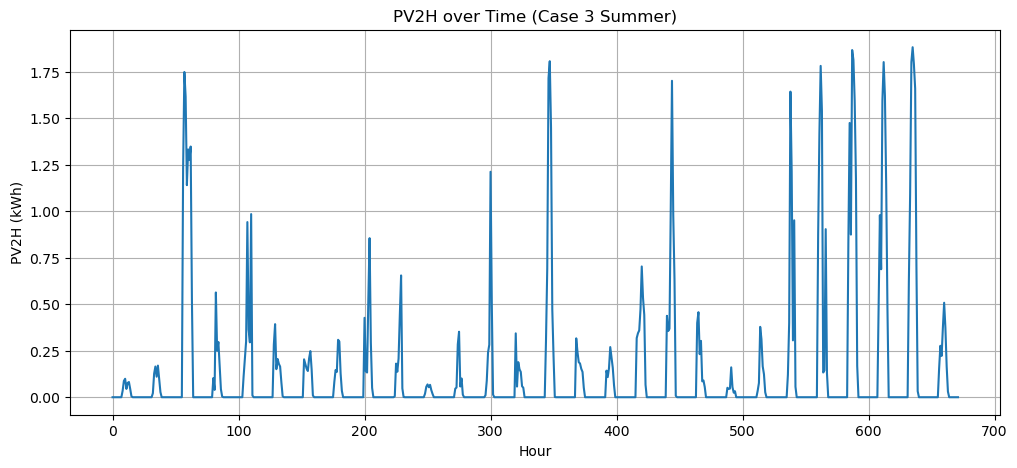

In [71]:
plt.figure(figsize=(12, 5))
plt.plot(merged_data_winter_case_3['PV_energy_production_kWh'])
plt.title('PV2H over Time (Case 3 Summer)')
plt.xlabel('Hour')
plt.ylabel('PV2H (kWh)')
plt.grid(True)
plt.show()

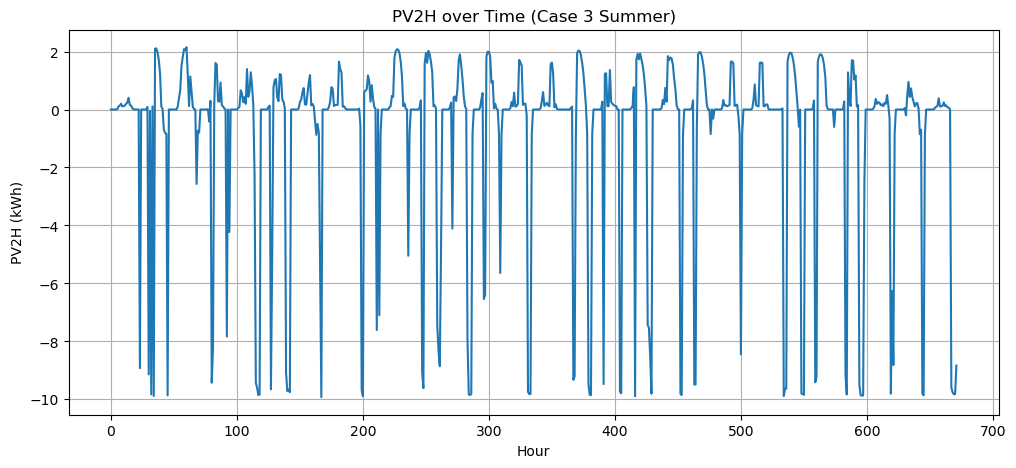

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(results_df['PV2H'])
plt.title('PV2H over Time (Case 3 Summer)')
plt.xlabel('Hour')
plt.ylabel('PV2H (kWh)')
plt.grid(True)
plt.show()


